# **PREDICTING HEART DISEASE RISK USING A RANDOM FOREST CLASSIFIER : A MACHINE LEARNING APPROACH**



> Note: Some non-essential code, like the one used for plotting graphs and heatmap, was previously commented out. In order to view the complete graph, the code needs to be uncommented. This adjustment was made to reduce the execution time.



# Imports & Load Data

In [36]:
!pip install imblearn

In [103]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import  classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, RocCurveDisplay, roc_auc_score, recall_score, precision_score, f1_score
from scipy.stats import norm
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LassoCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.ensemble import RandomForestClassifier

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
df = pd.read_csv('/content/drive/MyDrive/Capstone Project/heart_2022_with_nans.csv')
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,NaN,No,...,NaN,NaN,NaN,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
1,Alabama,Female,Excellent,0.0,0.0,NaN,No,6.0,NaN,No,...,1.60,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,NaN,No,...,1.57,63.50,25.61,No,No,No,No,NaN,No,Yes
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,NaN,No,...,1.65,63.50,23.30,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,NaN,No,...,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No


# EDA and Data Preprocessing




In [40]:
# Identify Data Types
df.dtypes

State                         object
Sex                           object
GeneralHealth                 object
PhysicalHealthDays           float64
MentalHealthDays             float64
LastCheckupTime               object
PhysicalActivities            object
SleepHours                   float64
RemovedTeeth                  object
HadHeartAttack                object
HadAngina                     object
HadStroke                     object
HadAsthma                     object
HadSkinCancer                 object
HadCOPD                       object
HadDepressiveDisorder         object
HadKidneyDisease              object
HadArthritis                  object
HadDiabetes                   object
DeafOrHardOfHearing           object
BlindOrVisionDifficulty       object
DifficultyConcentrating       object
DifficultyWalking             object
DifficultyDressingBathing     object
DifficultyErrands             object
SmokerStatus                  object
ECigaretteUsage               object
C

In [41]:
df.shape

(445132, 40)

> **Drop duplicated values**

In [42]:
df.duplicated().sum()

157

In [43]:
# Drop duplicated values
df.drop_duplicates(keep='first', inplace=True)

> **Null checking**

In [44]:
df.isnull().sum()

State                            0
Sex                              0
GeneralHealth                 1193
PhysicalHealthDays           10922
MentalHealthDays              9062
LastCheckupTime               8301
PhysicalActivities            1088
SleepHours                    5448
RemovedTeeth                 11355
HadHeartAttack                3060
HadAngina                     4400
HadStroke                     1552
HadAsthma                     1768
HadSkinCancer                 3138
HadCOPD                       2214
HadDepressiveDisorder         2807
HadKidneyDisease              1921
HadArthritis                  2628
HadDiabetes                   1082
DeafOrHardOfHearing          20502
BlindOrVisionDifficulty      21419
DifficultyConcentrating      24095
DifficultyWalking            23867
DifficultyDressingBathing    23770
DifficultyErrands            25511
SmokerStatus                 35316
ECigaretteUsage              35514
ChestScan                    55900
RaceEthnicityCategor

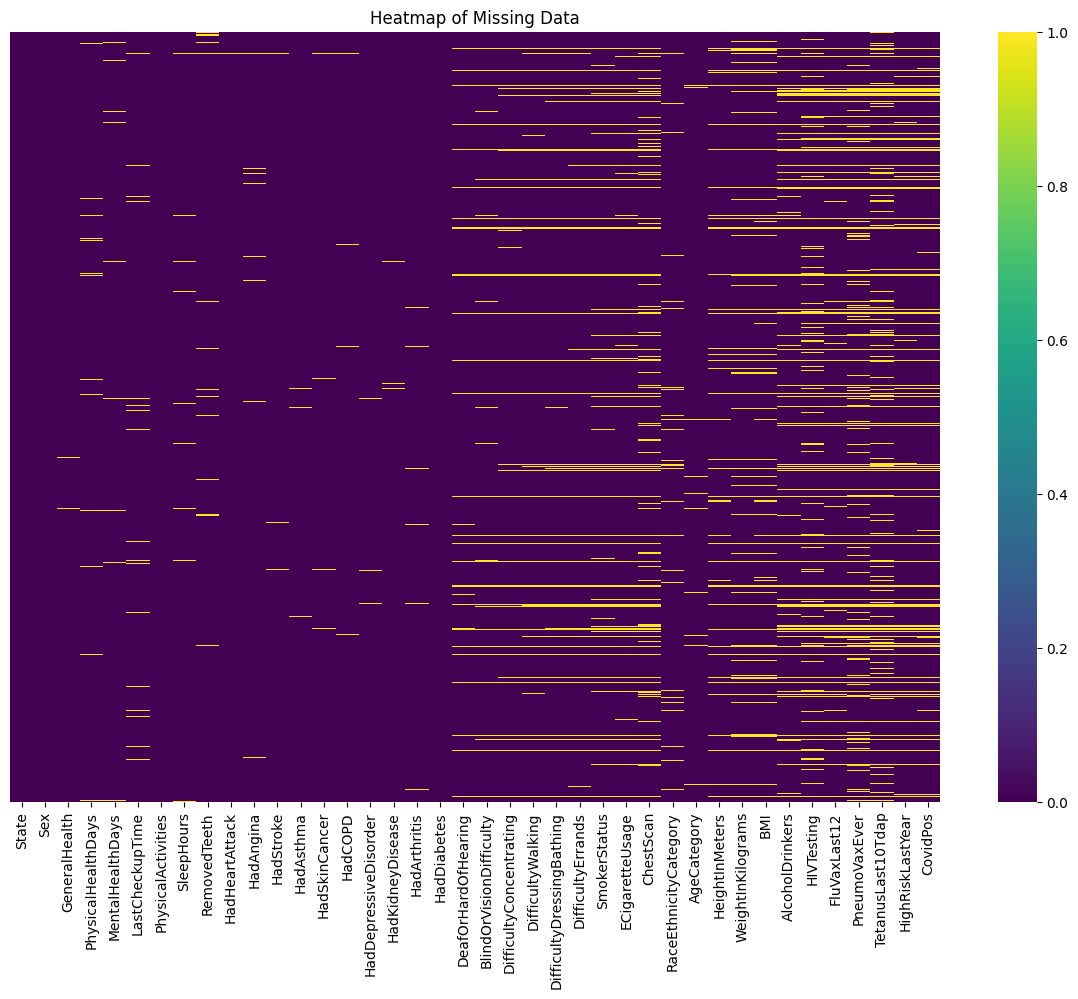

In [45]:
# # Heatmap to dentify Missing Data

# plt.figure(figsize=(15,10))
# ax = sns.heatmap(df.isnull(), cmap='viridis', cbar=True)
# ax.set_yticks([])
# plt.title('Heatmap of Missing Data')
# plt.show()

> **Columns having less than 1% of null values**

In [46]:
cols = [i for i in df.columns if df[i].isnull().mean() < 0.01]
cols

['State',
 'Sex',
 'GeneralHealth',
 'PhysicalActivities',
 'HadHeartAttack',
 'HadAngina',
 'HadStroke',
 'HadAsthma',
 'HadSkinCancer',
 'HadCOPD',
 'HadDepressiveDisorder',
 'HadKidneyDisease',
 'HadArthritis',
 'HadDiabetes']

In [47]:
df = df.dropna(subset=cols)
df.shape

(424586, 40)

> **Drop unnecessary columns**

In [48]:
# Drop unnecessary columns
columns = ['State','DeafOrHardOfHearing','LastCheckupTime', 'RemovedTeeth', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking',
           'DifficultyDressingBathing', 'DifficultyErrands', 'ECigaretteUsage', 'ChestScan', 'HIVTesting', 'FluVaxLast12', 'TetanusLast10Tdap']

df.drop(columns, axis=1, inplace=True)

In [50]:
df.columns

Index(['Sex', 'GeneralHealth', 'PhysicalHealthDays', 'MentalHealthDays',
       'PhysicalActivities', 'SleepHours', 'HadHeartAttack', 'HadAngina',
       'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'SmokerStatus', 'RaceEthnicityCategory', 'AgeCategory',
       'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers',
       'PneumoVaxEver', 'HighRiskLastYear', 'CovidPos'],
      dtype='object')

In [51]:
df1 = df.copy()

> **Function for random imputation in a column**

In [52]:
def random_impute(series):
    # Filter out the non-missing values
    non_missing = series.dropna()
    # Replace missing values with a random selection of non-missing values
    imputed = series.apply(lambda x: np.random.choice(non_missing) if pd.isnull(x) else x)
    return imputed

> **Edit some details in the column**





In [53]:
# Edit details in some columns

df1['HadDiabetes'].replace({'No, pre-diabetes or borderline diabetes' : 'Borderline',
                            'Yes, but only during pregnancy (female)' : 'During Pregnancy'} , inplace=True)

df1['SmokerStatus'].replace({'Never smoked' : 'Never',
                                        'Current smoker - now smokes some days' : 'Somedays',
                                        'Former smoker' : 'Former',
                                        'Current smoker - now smokes every day' : 'Everyday'}, inplace=True)

df1['RaceEthnicityCategory'].replace({'White only, Non-Hispanic' : 'White',
                                             'Black only, Non-Hispanic' : 'Black',
                                             'Other race only, Non-Hispanic' : 'Others',
                                             'Multiracial, Non-Hispanic' : 'Multi Racial'}, inplace=True)

df1['AgeCategory'].replace({
    'Age 80 or older' : '80+',
    'Age 75 to 79' : '75-79',
    'Age 70 to 74' : '70-74',
    'Age 65 to 69' : '65-69',
    'Age 60 to 64' : '60-64',
    'Age 55 to 59' : '55-59',
    'Age 50 to 54' : '50-54',
    'Age 45 to 49' : '45-49',
    'Age 40 to 44' : '40-44',
    'Age 35 to 39' : '35-39',
    'Age 30 to 34' : '30-34',
    'Age 25 to 29' : '25-29',
    'Age 18 to 24' : '18-24',}, inplace=True)

df1['CovidPos'].replace({'Tested positive using home test without a health professional' : 'Yes'}, inplace=True)

for col in df1.describe(include='object').columns:
    print('Column Name: ',col)
    print(df1[col].unique())
    print('-------------------------------------------------')

Column Name:  Sex
['Female' 'Male']
-------------------------------------------------
Column Name:  GeneralHealth
['Very good' 'Excellent' 'Fair' 'Poor' 'Good']
-------------------------------------------------
Column Name:  PhysicalActivities
['No' 'Yes']
-------------------------------------------------
Column Name:  HadHeartAttack
['No' 'Yes']
-------------------------------------------------
Column Name:  HadAngina
['No' 'Yes']
-------------------------------------------------
Column Name:  HadStroke
['No' 'Yes']
-------------------------------------------------
Column Name:  HadAsthma
['No' 'Yes']
-------------------------------------------------
Column Name:  HadSkinCancer
['No' 'Yes']
-------------------------------------------------
Column Name:  HadCOPD
['No' 'Yes']
-------------------------------------------------
Column Name:  HadDepressiveDisorder
['No' 'Yes']
-------------------------------------------------
Column Name:  HadKidneyDisease
['No' 'Yes']
---------------------



> **Checking for distribution**



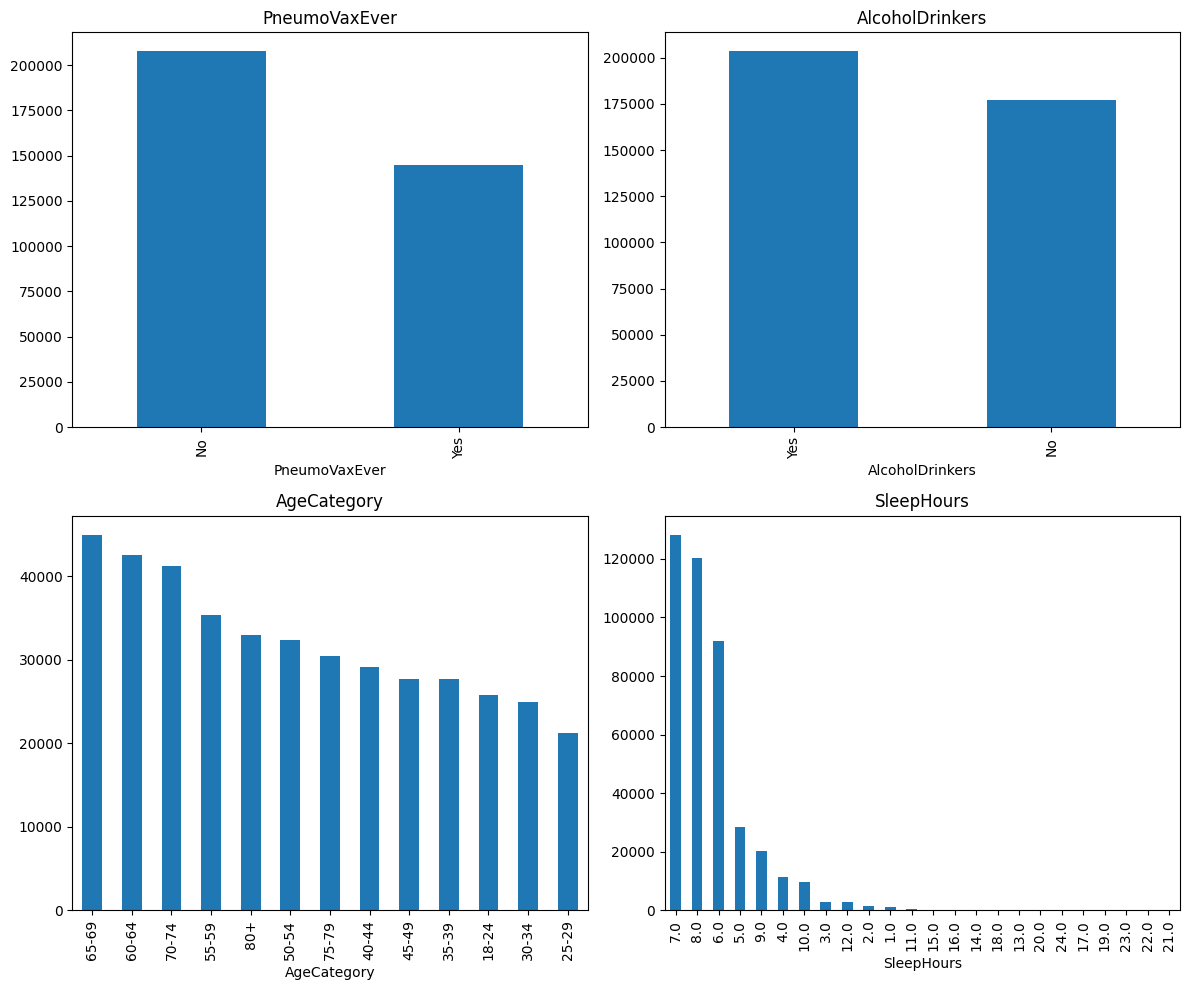

In [54]:
# # Creating subplots
# fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# # Plotting each value count as a bar chart
# df1['PneumoVaxEver'].value_counts().plot(kind='bar', ax=axs[0, 0], title='PneumoVaxEver')
# df1['AlcoholDrinkers'].value_counts().plot(kind='bar', ax=axs[0, 1], title='AlcoholDrinkers')
# df1['AgeCategory'].value_counts().plot(kind='bar', ax=axs[1, 0], title='AgeCategory')
# df1['SleepHours'].value_counts().plot(kind='bar', ax=axs[1, 1], title='SleepHours')

# plt.tight_layout()
# plt.show()

In [55]:
# Define the random_impute function
def random_impute(series):
    non_null_values = series.dropna()
    return series.apply(lambda x: np.random.choice(non_null_values) if pd.isnull(x) else x)

# Apply random_impute to each column and check for null values
df1['PneumoVaxEver'] = random_impute(df1['PneumoVaxEver'])
pneumo_nulls = df1['PneumoVaxEver'].isnull().sum()

df1['AlcoholDrinkers'] = random_impute(df1['AlcoholDrinkers'])
alcohol_nulls = df1['AlcoholDrinkers'].isnull().sum()

df1['AgeCategory'] = random_impute(df1['AgeCategory'])
age_nulls = df1['AgeCategory'].isnull().sum()

df1['SleepHours'] = random_impute(df1['SleepHours'])
sleep_nulls = df1['SleepHours'].isnull().sum()

> **Checking for mode imputation**

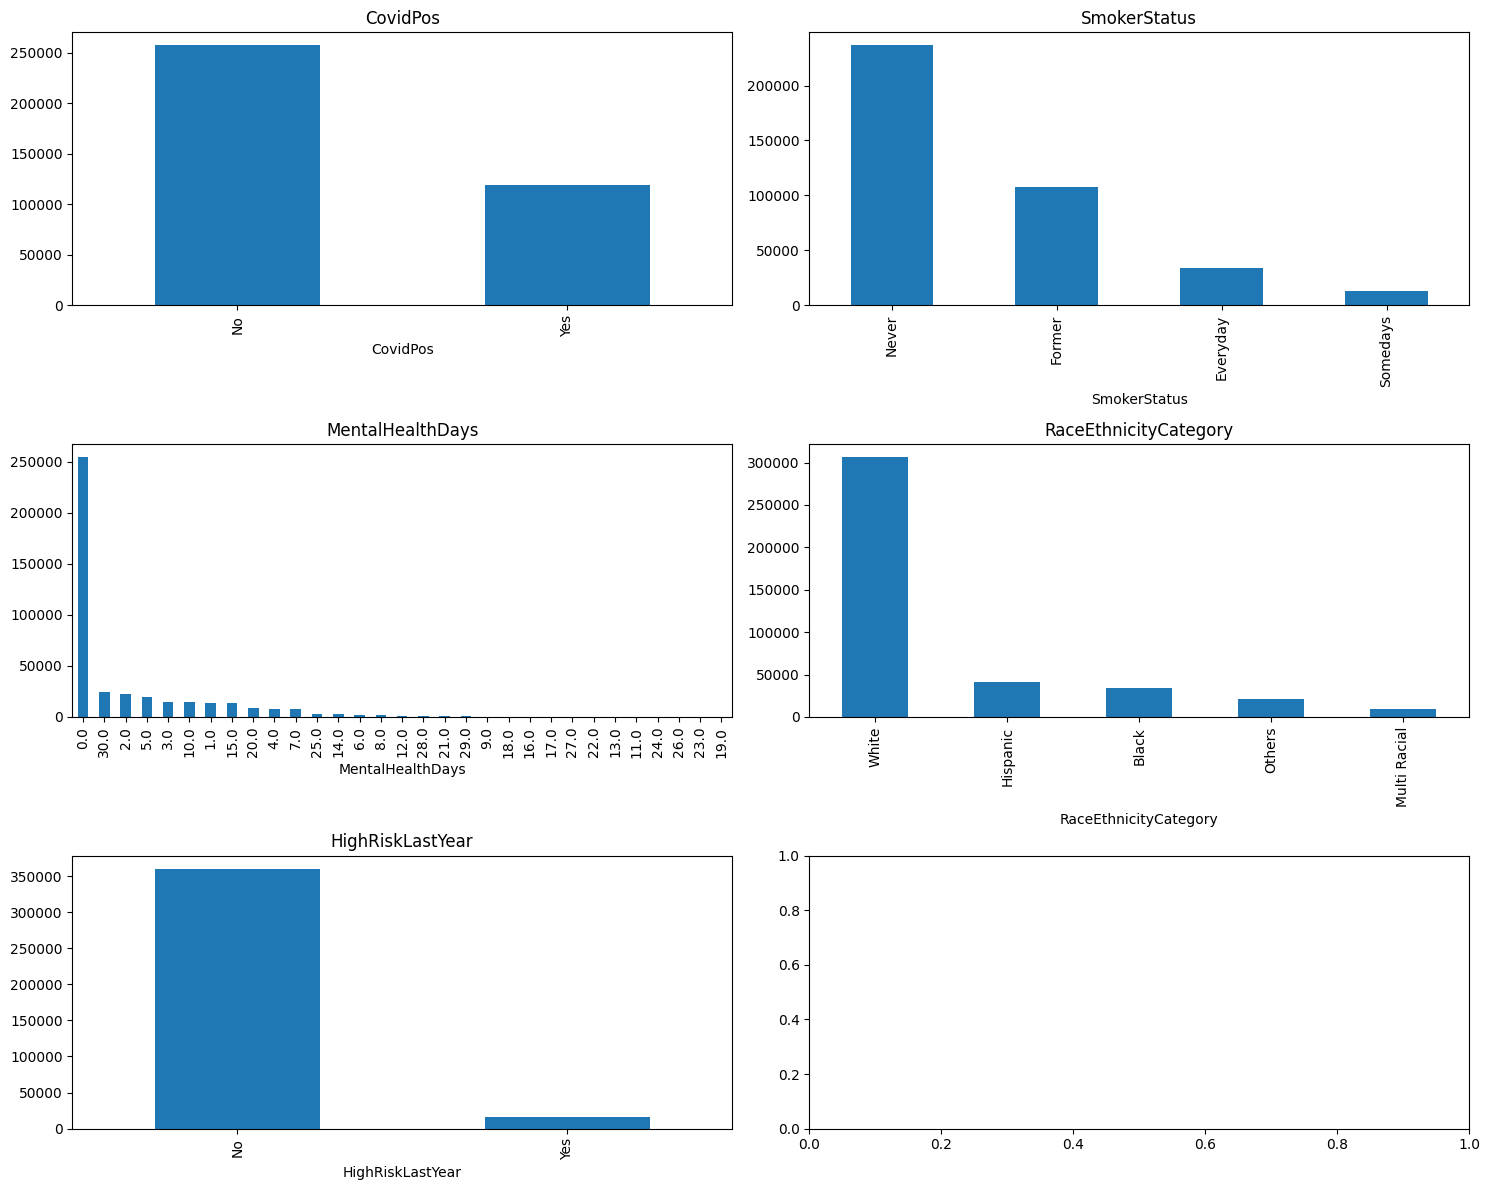

In [56]:
# # Creating subplots for the new columns
# fig, axs = plt.subplots(3, 2, figsize=(15, 12))

# # Plotting each value count as a bar chart
# df1['CovidPos'].value_counts().plot(kind='bar', ax=axs[0, 0], title='CovidPos')
# df1['SmokerStatus'].value_counts().plot(kind='bar', ax=axs[0, 1], title='SmokerStatus')
# df1['MentalHealthDays'].value_counts().plot(kind='bar', ax=axs[1, 0], title='MentalHealthDays')
# df1['RaceEthnicityCategory'].value_counts().plot(kind='bar', ax=axs[1, 1], title='RaceEthnicityCategory')
# df1['HighRiskLastYear'].value_counts().plot(kind='bar', ax=axs[2, 0], title='HighRiskLastYear')

# plt.tight_layout()
# plt.show()

In [57]:
# Define a function to fill missing values with the mode of the column
def fill_missing_with_mode(df, column):
    mode_value = df[column].mode()[0]
    df[column].fillna(value=mode_value, inplace=True)
    return df[column].isnull().sum()

# Apply the function to the specified columns
null_counts = {
    'CovidPos': fill_missing_with_mode(df1, 'CovidPos'),
    'SmokerStatus': fill_missing_with_mode(df1, 'SmokerStatus'),
    'MentalHealthDays': fill_missing_with_mode(df1, 'MentalHealthDays'),
    'RaceEthnicityCategory': fill_missing_with_mode(df1, 'RaceEthnicityCategory'),
    'HighRiskLastYear': fill_missing_with_mode(df1, 'HighRiskLastYear')
}

null_counts

{'CovidPos': 0,
 'SmokerStatus': 0,
 'MentalHealthDays': 0,
 'RaceEthnicityCategory': 0,
 'HighRiskLastYear': 0}

> **Imputation for continuous columns**

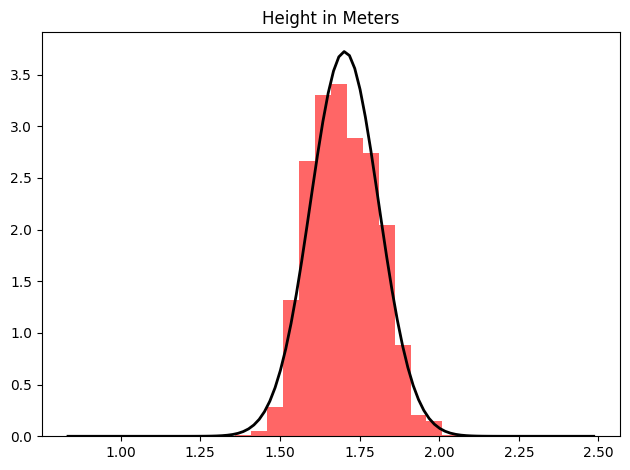

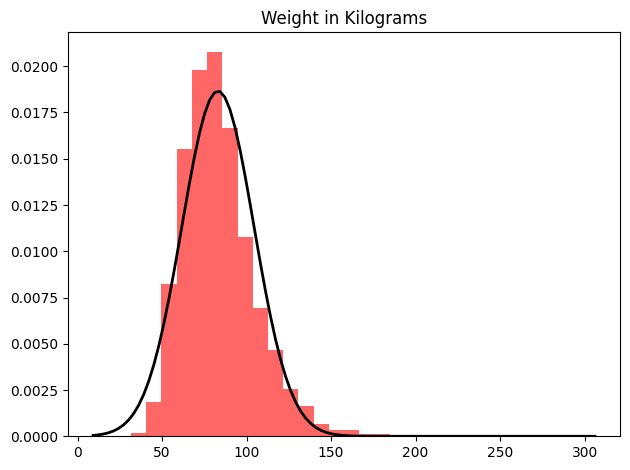

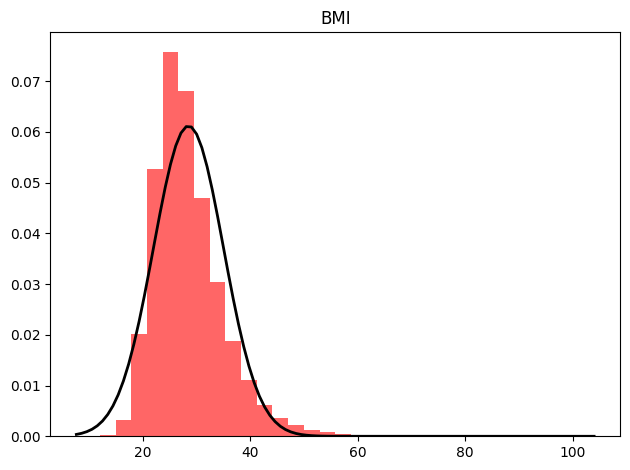

In [61]:
# Function to plot histogram and fit normal distribution
def plot_hist_and_fit_normal(data, title):
    plt.hist(data.dropna(), bins=30, density=True, alpha=0.6, color='r')

    # Fit a normal distribution to the data: Calculate mean and standard deviation
    mu, std = norm.fit(data.dropna())

    # Plot the normal curve
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    plt.plot(x, p, 'k', linewidth=2)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot for HeightInMeters
plot_hist_and_fit_normal(df1['HeightInMeters'], 'Height in Meters')

# Plot for WeightInKilograms
plot_hist_and_fit_normal(df1['WeightInKilograms'], 'Weight in Kilograms')

# Plot for BMI
plot_hist_and_fit_normal(df1['BMI'], 'BMI')

In [59]:
# HeightInMeters

# Set random seed for reproducibility
np.random.seed(42)

# Isolate non-missing values from the column 'HeightInMeters'
non_missing_values = df1['HeightInMeters'].dropna()

# Perform random imputation for missing values in 'HeightInMeters'
df1['HeightInMeters'] = df1['HeightInMeters'].apply(
    lambda x: np.random.choice(non_missing_values) if pd.isnull(x) else x
)

# Check for null values in 'HeightInMeters'
height_nulls = df1['HeightInMeters'].isnull().sum()

In [64]:
# Initialize KNNImputer
knn = KNNImputer(n_neighbors=3, weights='distance')

In [65]:
# WeightInKilograms

# Perform KNN imputation for 'WeightInKilograms'
df1[['WeightInKilograms']] = knn.fit_transform(df1[['WeightInKilograms']])
weight_nulls = df1['WeightInKilograms'].isnull().sum()

In [66]:
# BMI

# Perform KNN imputation for 'BMI'
df1[['BMI']] = knn.fit_transform(df1[['BMI']])
bmi_nulls = df1['BMI'].isnull().sum()

> **Checking for null values after handling missing values**

In [67]:
df1.isnull().sum()

Sex                         0
GeneralHealth               0
PhysicalHealthDays       9274
MentalHealthDays            0
PhysicalActivities          0
SleepHours                  0
HadHeartAttack              0
HadAngina                   0
HadStroke                   0
HadAsthma                   0
HadSkinCancer               0
HadCOPD                     0
HadDepressiveDisorder       0
HadKidneyDisease            0
HadArthritis                0
HadDiabetes                 0
SmokerStatus                0
RaceEthnicityCategory       0
AgeCategory                 0
HeightInMeters              0
WeightInKilograms           0
BMI                         0
AlcoholDrinkers             0
PneumoVaxEver               0
HighRiskLastYear            0
CovidPos                    0
dtype: int64

> **Correlation heatmap**

<Axes: >

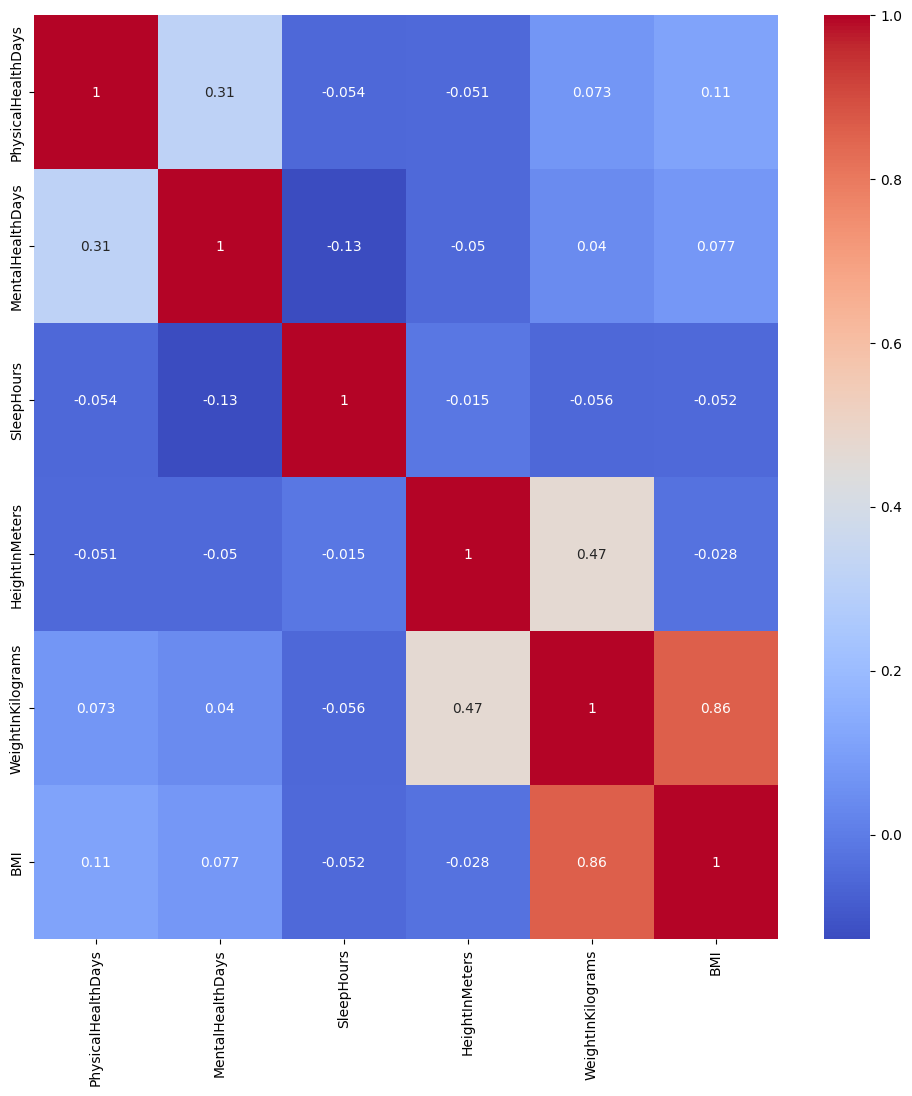

In [68]:
# # Plot correlation heatmap
# plt.figure(figsize=(12,12))
# sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')

In [69]:
# Dropping 'WeightInKilograms' because the correlation with 'BMI' that may cause redundancy
df1.drop('WeightInKilograms', inplace=True, axis=1)

> **Outlier handling**

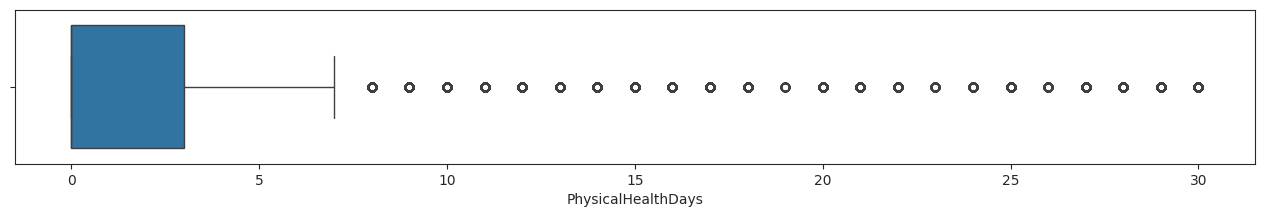

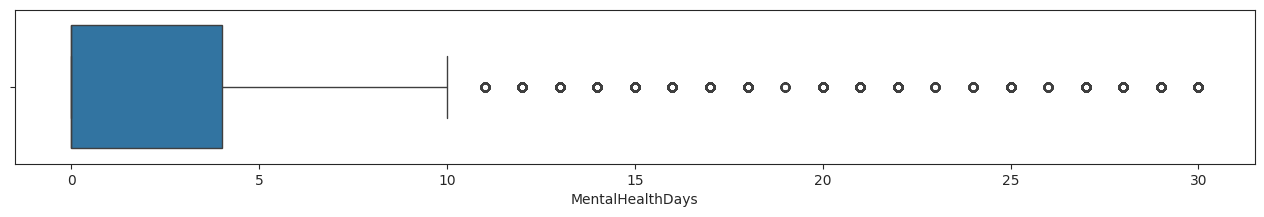

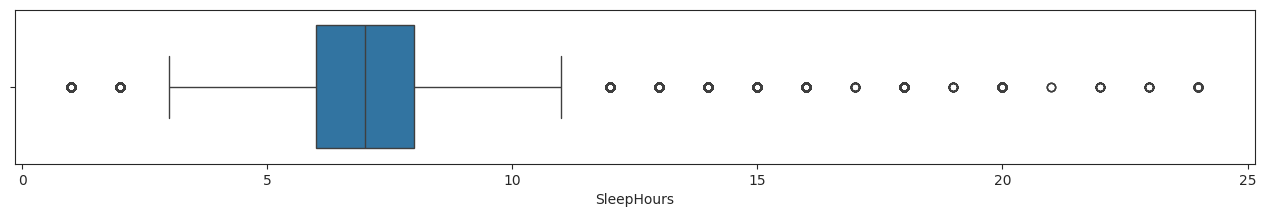

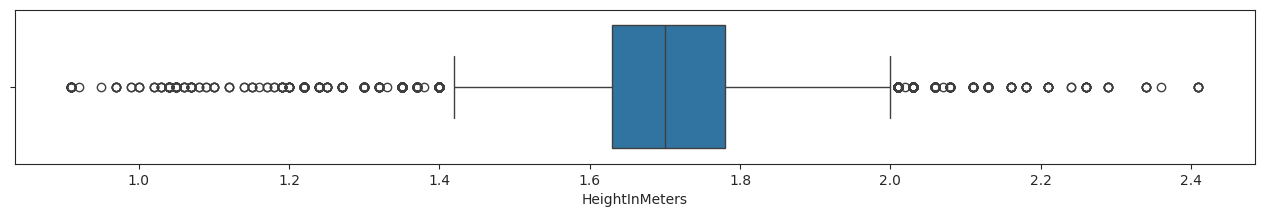

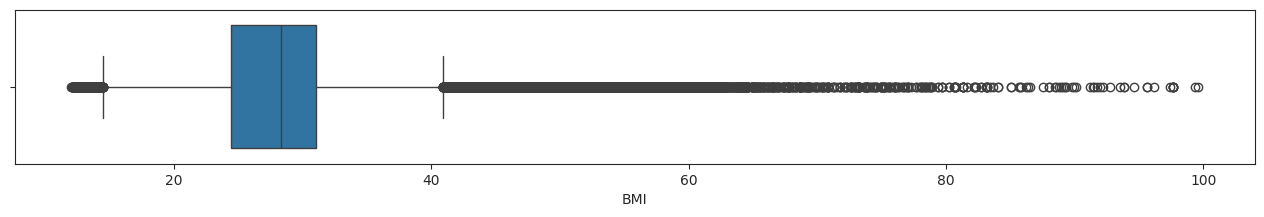

In [70]:
# # Identify Outliers using box plots
# for col in df1.describe().columns:
#     sns.set_style('ticks')
#     plt.figure(figsize=(16, 2))
#     sns.boxplot(data=df1, x=col)
#     plt.show()

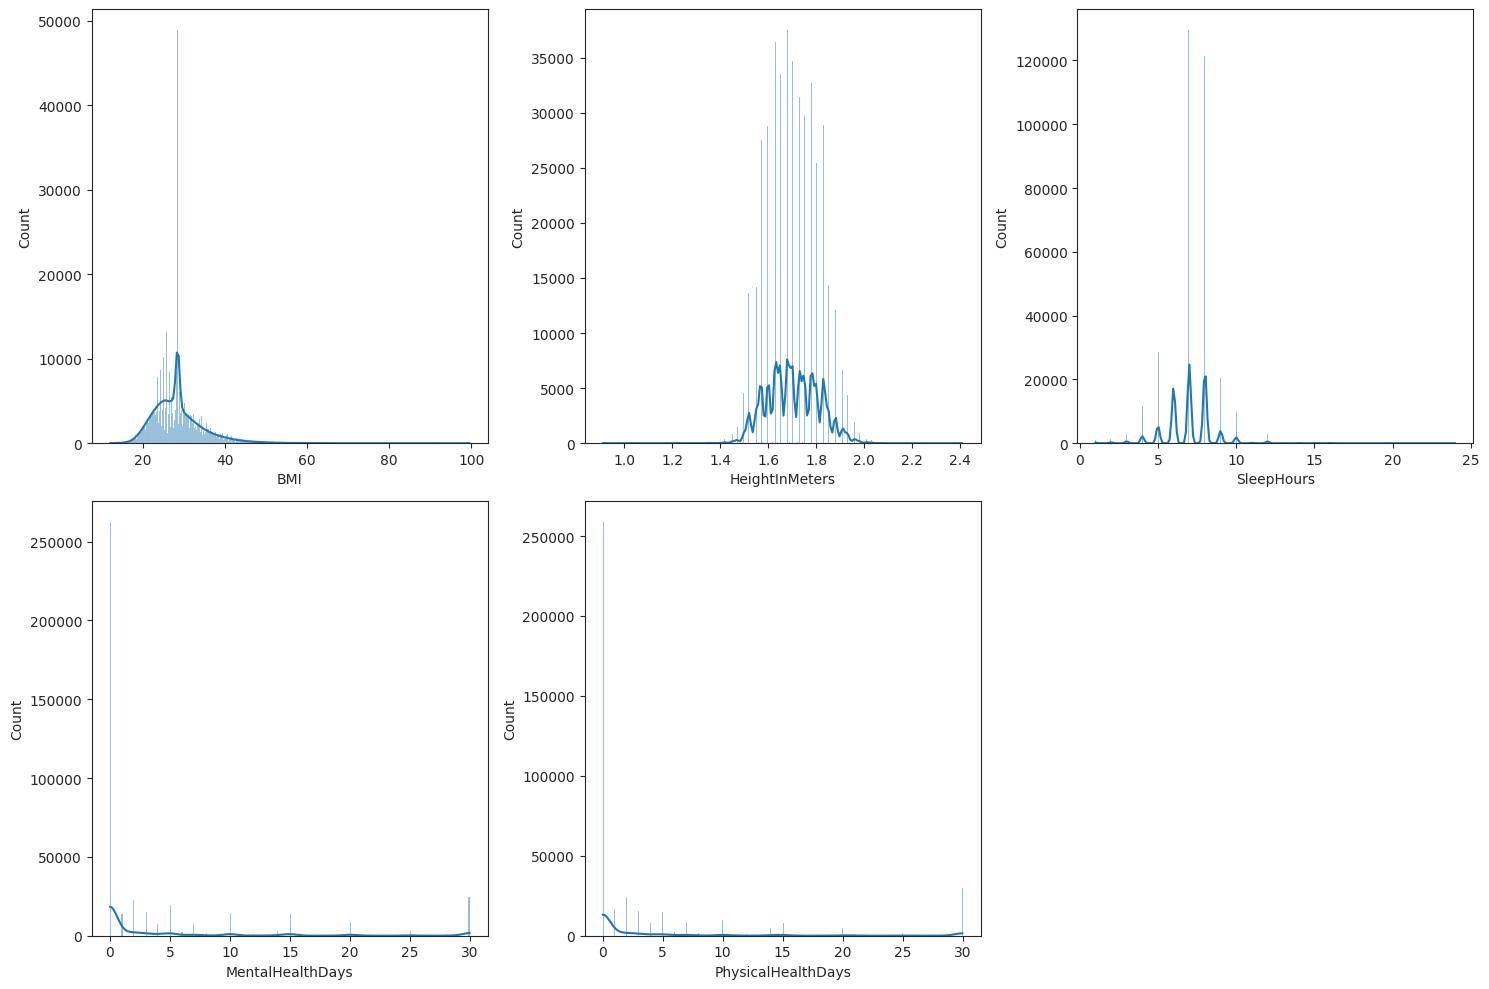

In [73]:
# # Histogram for outliers
# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# sns.histplot(df1['BMI'], kde=True, ax=axes[0, 0])

# sns.histplot(df1['HeightInMeters'], kde=True, ax=axes[0, 1])

# sns.histplot(df1['SleepHours'], kde=True, ax=axes[0, 2])

# sns.histplot(df1['MentalHealthDays'], kde=True, ax=axes[1, 0])

# sns.histplot(df1['PhysicalHealthDays'], kde=True, ax=axes[1, 1])

# fig.delaxes(axes[1][2])
# plt.tight_layout()
# plt.show()

In [74]:
# Calculate skewness for numeric columns
skewness = df1.select_dtypes(include=['number']).skew()

# Analyze and print skewness categories
skewness_analysis = {}
for col, value in skewness.items():
    if value > 1 or value < -1:
        skewness_analysis[col] = "highly skewed distribution"
    elif value > 0.5 or value < -0.5:
        skewness_analysis[col] = "moderately skewed distribution"
    else:
        skewness_analysis[col] = "approximately symmetric"

# Display the analysis
skewness_analysis

{'PhysicalHealthDays': 'highly skewed distribution',
 'MentalHealthDays': 'highly skewed distribution',
 'SleepHours': 'moderately skewed distribution',
 'HeightInMeters': 'approximately symmetric',
 'BMI': 'highly skewed distribution'}

> **Removing outliers**

In [75]:
# Function to get outliers and print limits
def get_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_limit) | (df[column] > upper_limit)]
    return outliers, lower_limit, upper_limit

# Function to print outliers and limits for specified columns
def print_outliers_and_limits(df, columns):
    for column in columns:
        outliers, lower_limit, upper_limit = get_outliers(df, column)
        print(f"{column} Outliers:")
        print(f"Lower Limit: {lower_limit}")
        print(f"Upper Limit: {upper_limit}")
        print(outliers)
        print()

# Columns to check for outliers
columns_to_check = ['BMI', 'PhysicalHealthDays', 'MentalHealthDays', 'SleepHours']

# Print outliers and limits for the specified columns
print_outliers_and_limits(df1, columns_to_check)

BMI Outliers:
Lower Limit: 14.509999999999998
Upper Limit: 40.910000000000004
           Sex GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
23      Female          Poor                30.0               0.0   
48      Female          Good                 0.0              18.0   
49      Female          Good                 0.0               0.0   
54        Male          Fair                 3.0               0.0   
142     Female          Fair                30.0              20.0   
...        ...           ...                 ...               ...   
445021  Female     Very good                10.0               0.0   
445024  Female     Very good                 0.0               0.0   
445029  Female          Good                 0.0               0.0   
445081  Female          Good                 2.0              10.0   
445082  Female          Fair                 0.0               3.0   

       PhysicalActivities  SleepHours HadHeartAttack HadAngina HadStroke  \
23   

In [76]:
# Function to remove outliers from a column based on IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    df = df.drop(df[(df[column] < lower_limit) | (df[column] > upper_limit)].index)
    return df

# Function to handle outliers for specified columns
def handle_outliers(df, columns):
    for column in columns:
        df = remove_outliers(df, column)
    return df

# Handle outliers for the specified columns in df1
df1_cleaned = handle_outliers(df1, columns_to_check)

# Reset index after removing rows
df1_cleaned.reset_index(drop=True, inplace=True)

# Check the shape of the DataFrame after removing outliers
print(f"Shape of DataFrame after removing outliers: {df1_cleaned.shape}")

Shape of DataFrame after removing outliers: (290048, 25)


In [77]:
# Handling outliers for 'HeightInMeters' using Z-score method
df1['HeightInMeters_zscore'] = (df1['HeightInMeters'] - df1['HeightInMeters'].mean()) / df1['HeightInMeters'].std()

# Identify and cap outliers
upper_limit = df1['HeightInMeters'].mean() + 3 * df1['HeightInMeters'].std()
lower_limit = df1['HeightInMeters'].mean() - 3 * df1['HeightInMeters'].std()
df1['HeightInMeters'] = np.where(df1['HeightInMeters'] > upper_limit, upper_limit,
                                 np.where(df1['HeightInMeters'] < lower_limit, lower_limit, df1['HeightInMeters']))

# Drop the z-score column
df1.drop("HeightInMeters_zscore", axis=1, inplace=True)

# Check the shape of the DataFrame after handling outliers
print(f"Shape of DataFrame after handling outliers: {df1.shape}")

Shape of DataFrame after handling outliers: (424586, 25)


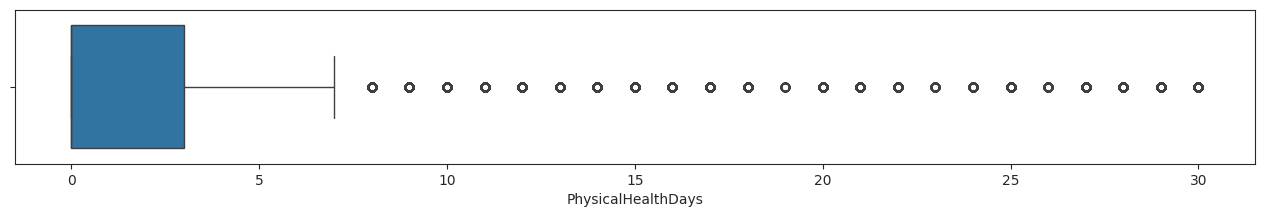

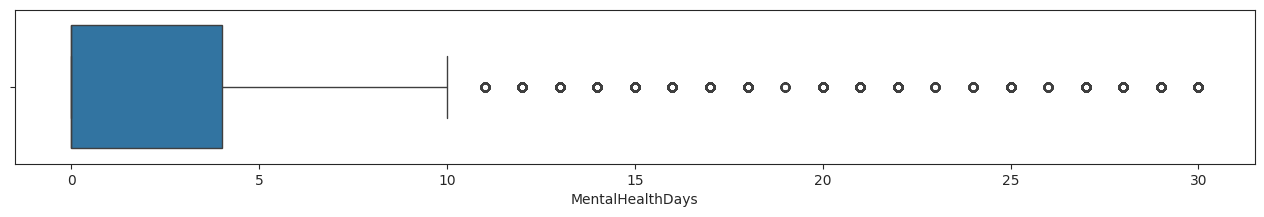

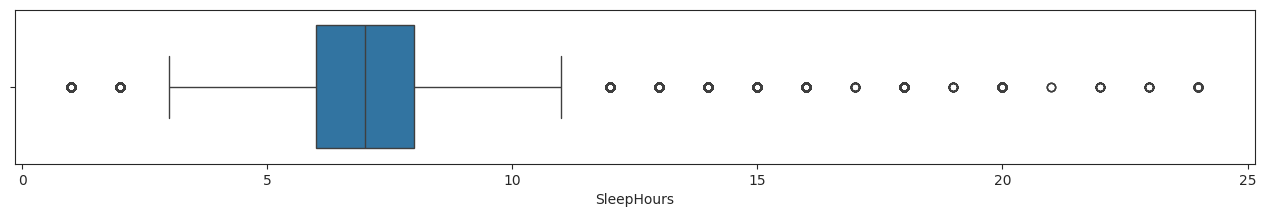

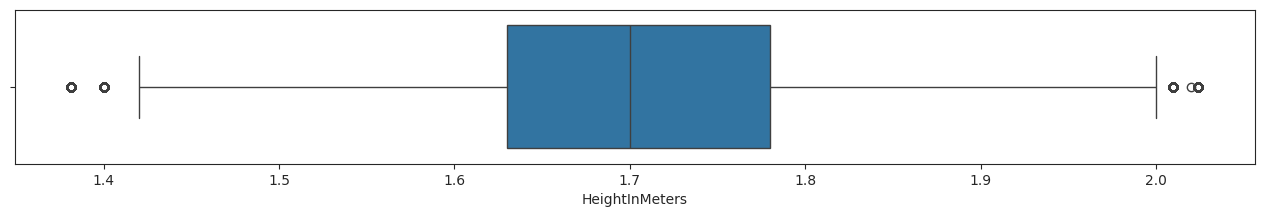

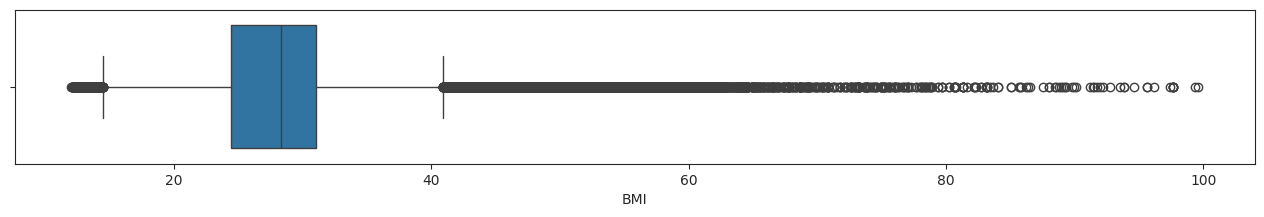

In [78]:
# Check box plots after removing outliers
for col in df1.describe().columns:
    sns.set_style('ticks')
    plt.figure(figsize=(16, 2))
    sns.boxplot(data=df1, x=col)
    plt.show()

> **Handling Categorical Values**

In [79]:
# Define the ColumnTransformer with OneHotEncoder and OrdinalEncoder
transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False, drop='first'),
         ['Sex', 'PhysicalActivities', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer',
          'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes',
          'SmokerStatus', 'RaceEthnicityCategory', 'AlcoholDrinkers', 'PneumoVaxEver', 'HighRiskLastYear',
          'CovidPos']),
        ('ordinal', OrdinalEncoder(categories=[
            ['Poor', 'Fair', 'Good', 'Very good', 'Excellent'],
            ['80+', '75-79', '70-74', '65-69', '60-64', '55-59', '50-54', '45-49', '40-44', '35-39', '30-34', '25-29', '18-24']
        ]), ['GeneralHealth', 'AgeCategory'])
    ],
    remainder='passthrough'
)

# Fit and transform the data
df2 = transformer.fit_transform(df1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [80]:
# Define the function to get feature names
def get_feature_names(columnTransformer):
    # Extract the original column names
    original_column_names = columnTransformer.feature_names_in_

    # Initialize an empty list for the final feature names
    feature_names = []

    # Loop through each transformer in the column transformer
    for transformer_info in columnTransformer.transformers_:
        transformer_name, transformer, cols = transformer_info

        # If it's not the remainder transformer
        if transformer_name != 'remainder':
            if hasattr(transformer, 'get_feature_names_out'):
                # For transformers with get_feature_names_out method
                feature_names.extend(transformer.get_feature_names_out(cols))
            else:
                # For transformers without get_feature_names_out method
                feature_names.extend(cols)
        else:
            # Handling the remainder case
            if transformer == 'passthrough':
                feature_names.extend(original_column_names[cols])
            elif transformer is None:
                pass  # If there's a transformer set to None (which means dropping the column)

    return feature_names

# Assuming the transformer has already been fit
updated_column_names = get_feature_names(transformer)

In [81]:
# Convert the transformed data back to a DataFrame with updated column names
df2 = pd.DataFrame(df2, columns=updated_column_names)

# Display the transformed DataFrame
print(df2.head())

  Sex_Male PhysicalActivities_Yes HadAngina_Yes HadStroke_Yes HadAsthma_Yes  \
0      0.0                    0.0           0.0           0.0           0.0   
1      0.0                    0.0           0.0           0.0           0.0   
2      0.0                    1.0           0.0           0.0           0.0   
3      0.0                    1.0           0.0           0.0           1.0   
4      0.0                    1.0           0.0           0.0           0.0   

  HadSkinCancer_Yes HadCOPD_Yes HadDepressiveDisorder_Yes  \
0               0.0         0.0                       0.0   
1               1.0         0.0                       0.0   
2               1.0         0.0                       0.0   
3               0.0         0.0                       0.0   
4               0.0         0.0                       0.0   

  HadKidneyDisease_Yes HadArthritis_Yes  ... HighRiskLastYear_Yes  \
0                  0.0              0.0  ...                  0.0   
1                  0

In [82]:
# Check for nulls after imputer
df2.isnull().sum()

Sex_Male                                 0
PhysicalActivities_Yes                   0
HadAngina_Yes                            0
HadStroke_Yes                            0
HadAsthma_Yes                            0
HadSkinCancer_Yes                        0
HadCOPD_Yes                              0
HadDepressiveDisorder_Yes                0
HadKidneyDisease_Yes                     0
HadArthritis_Yes                         0
HadDiabetes_During Pregnancy             0
HadDiabetes_No                           0
HadDiabetes_Yes                          0
SmokerStatus_Former                      0
SmokerStatus_Never                       0
SmokerStatus_Somedays                    0
RaceEthnicityCategory_Hispanic           0
RaceEthnicityCategory_Multi Racial       0
RaceEthnicityCategory_Others             0
RaceEthnicityCategory_White              0
AlcoholDrinkers_Yes                      0
PneumoVaxEver_Yes                        0
HighRiskLastYear_Yes                     0
CovidPos_Ye

In [83]:
df2 = df2.dropna(subset=['PhysicalHealthDays', 'BMI'])
df2.shape

(415312, 32)



> **Scaling the dataset**


In [84]:
# Scale specific columns using StandardScaler
scaler = StandardScaler()
columns_to_scale = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'BMI']
df3 = df2.copy()
df3[columns_to_scale] = scaler.fit_transform(df3[columns_to_scale])

In [85]:
df3.head()

,Sex_Male,PhysicalActivities_Yes,HadAngina_Yes,HadStroke_Yes,HadAsthma_Yes,HadSkinCancer_Yes,HadCOPD_Yes,HadDepressiveDisorder_Yes,HadKidneyDisease_Yes,HadArthritis_Yes,...,HighRiskLastYear_Yes,CovidPos_Yes,GeneralHealth,AgeCategory,PhysicalHealthDays,MentalHealthDays,SleepHours,HadHeartAttack,HeightInMeters,BMI
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,-0.491517,-0.513440,0.661810,No,1.193196,0.000407
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,-0.491517,-0.513440,-0.695760,No,-0.975090,-0.315573
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,3.0,5.0,-0.256440,-0.148009,-1.374545,No,-1.257910,-0.471542
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,4.0,3.0,-0.491517,-0.513440,-0.016975,No,-0.503724,-0.846843
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,8.0,-0.256440,-0.513440,1.340595,No,-1.257910,-1.095419




> **Encode the prediction column**



In [86]:
# Label encode the 'HadHeartAttack' column
le = LabelEncoder()
df3['HadHeartAttack'] = le.fit_transform(df3['HadHeartAttack'])

# Feature Selection

In [87]:
# Scale specific columns using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
columns_to_scale = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'BMI']
df4 = df2.copy()
df4[columns_to_scale] = scaler.fit_transform(df4[columns_to_scale])

In [88]:
# Define features and target for feature selection
X_required = df4.drop('HadHeartAttack', axis=1)
y_required = df4['HadHeartAttack']

> Lasso method to get significant features

In [91]:
y_required = y_required.map({'No': 0, 'Yes': 1})

In [93]:
# Train LassoCV model
lasso_cv = LassoCV(alphas=np.logspace(-4, 4, 100), cv=5, random_state=0)
lasso_cv.fit(X_required, y_required)

# Identify significant features
significant_mask = lasso_cv.coef_ != 0
significant_features_lasso = X_required.columns[significant_mask]
significant_coefficients = lasso_cv.coef_[significant_mask]

In [94]:
len(significant_features_lasso)

24

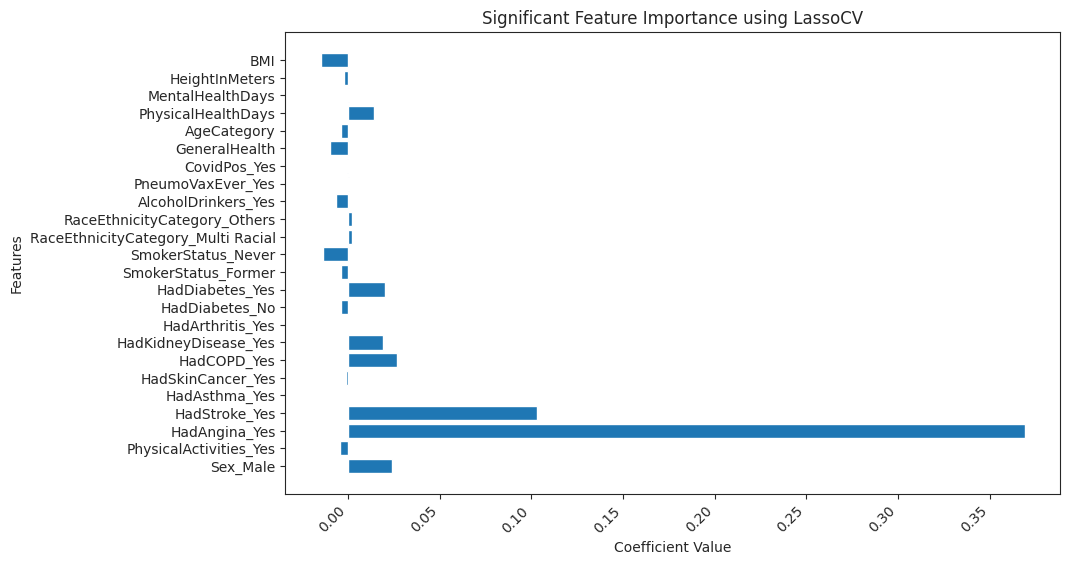

In [95]:
# Plot significant features
plt.figure(figsize=(10, 6))
plt.barh(significant_features_lasso, significant_coefficients)
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Significant Feature Importance using LassoCV')
plt.xticks(rotation=45, ha="right")  # Rotate feature names for better readability
plt.show()

# Handling imbalance data

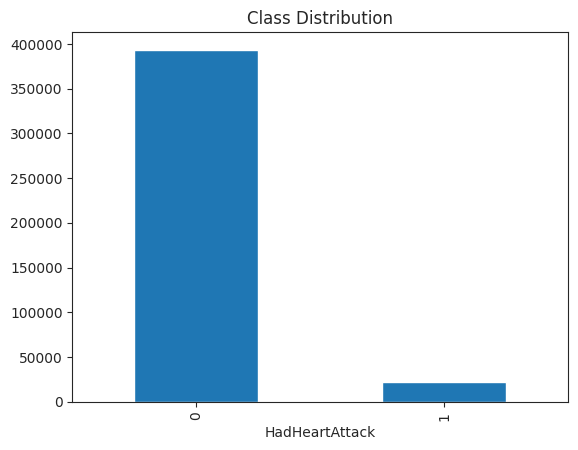

In [112]:
# # Check for class distribution of 'HadHeartAttack'
# df3['HadHeartAttack'].value_counts().plot(kind='bar')
# plt.title('Class Distribution')
# plt.show()

In [113]:
# Define features and target for imbalance data
X_balance = df3.drop('HadHeartAttack', axis=1)
y_balance = df3['HadHeartAttack']

Text(0.5, 1.0, 'Class Distribution After SMOTE')

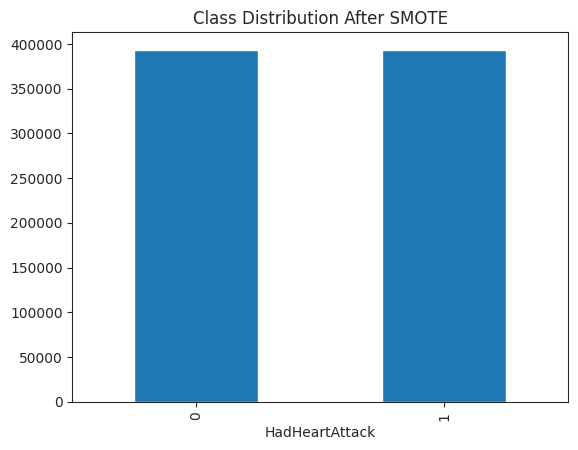

In [114]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_sm, y_sm = smote.fit_resample(X_balance, y_balance)

y_sm.value_counts().plot(kind='bar')
plt.title('Class Distribution After SMOTE')

# Model Training : Random Forest




In [115]:
# Define features and target for model training
X = X_sm[significant_features_lasso]
y = y_sm

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [118]:
# Ensure that the training and testing data are numeric
X_train = X_train.apply(pd.to_numeric)
X_test = X_test.apply(pd.to_numeric)

In [136]:
# Initialize random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test)

# Model Evaluation

In [137]:
# Print evaluation metric of the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

# Print the results
print(f"Final Validation Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Final Validation Accuracy: 0.9740
Precision: 0.9798
Recall: 0.9679
F1 Score: 0.9738
ROC AUC: 0.9960


In [138]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     78635
           1       0.98      0.97      0.97     78736

    accuracy                           0.97    157371
   macro avg       0.97      0.97      0.97    157371
weighted avg       0.97      0.97      0.97    157371


Confusion Matrix:
[[77067  1568]
 [ 2528 76208]]


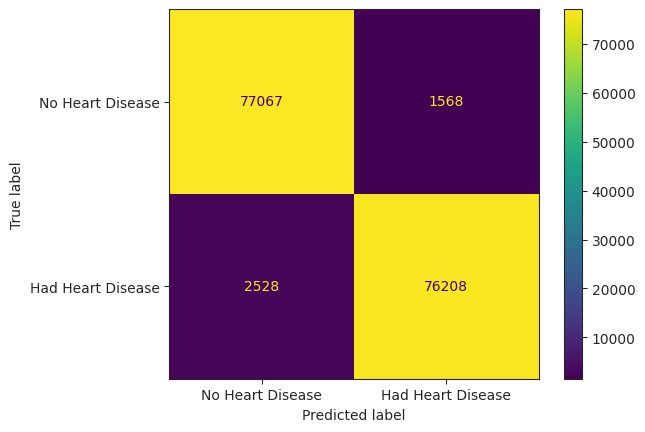

In [139]:
# Display confusion matrix
confusion = confusion_matrix(y_test, y_pred)
cm_dis= ConfusionMatrixDisplay(confusion, display_labels = ['No Heart Disease', 'Had Heart Disease'])
cm_dis.plot()

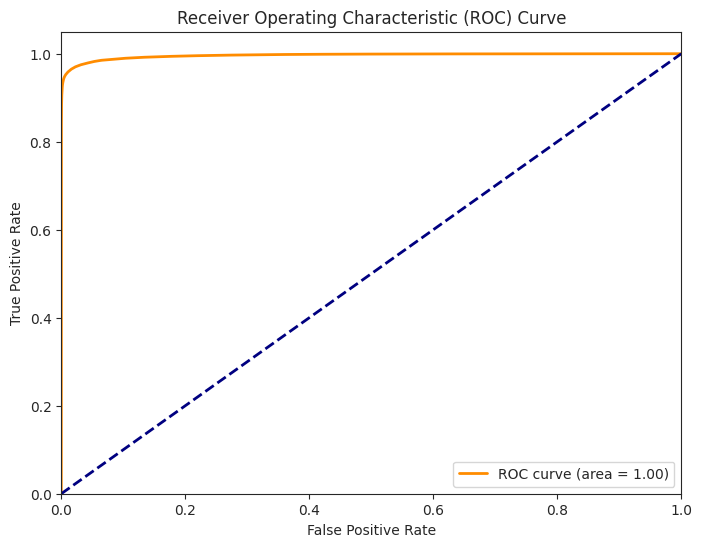

In [140]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()